__Probabilistic Programming. Wąsowski. Pardo. IT University of Copenhagen__

Some figures from 
* McElreath. _Statistical Rethinking. A Bayesian course with examples in R and STAN._ 2nd Ed.
* Kruschke. _Doing Bayesian Data Analysis. A tutorial with R, JAGS, and STAN._ 2nd Ed.

Adaptations of R examples to PymC courtesy of https://github.com/pymc-devs/resources/tree/master/Rethinking_2


In [1]:
import pymc as pm
import arviz as az
import math
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
import pandas as pd
import rethinking as rt
import xarray as xr

from causalgraphicalmodels import CausalGraphicalModel

import graphviz

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
hdi_fill_args = { 'color': 'black', 'alpha': 0.1 }

# Week 3.  Multiple Regression (McElreath Ch. 5)

**Key Point: Using regression for <s>prediction</s> understanding**

# Agenda

1. Exponential Distribution
2. Correlation is not causation
3. Confounding (spurious/too strong correlation because model too simple)
4. Counterfactuals
5. Masking (too weak correlation because model to simple)
6. Categorical variables


<br/><br/><br/><br/><br/><br/><br/><br/>

# An intuition about Exponential Distribution (Density Function)

<div style="text-align:centeleft">
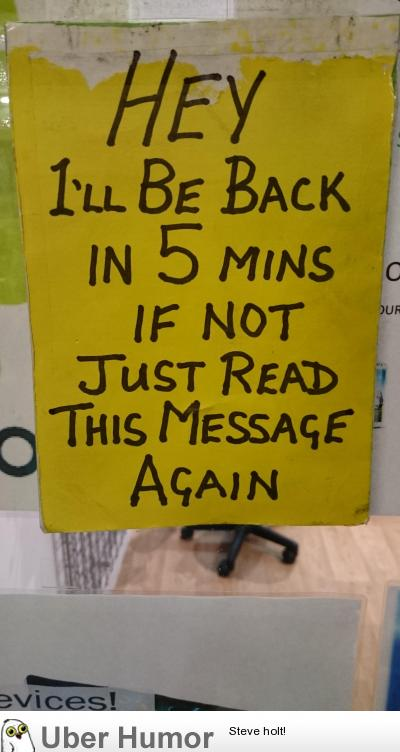
</div>

* Describes arrivals/departures/residence times, when expected time to arrival/departure/residence is known.
* If you condition it on any time in the future (remove a finite prefix), the expected waiting time does not change.

<br/><br/><br/><br/><br/><br/><br/><br/>

# Exponential, the math

* For $x \in \mathbb{R}_+$ we define a probability density function (pdf):

$$p(x) = \lambda e^{{-\lambda x}}$$

* where $\lambda$ is a positive parameter (the **rate**).  So like a Bernoulli distribution, exponential distribution has one parameter.

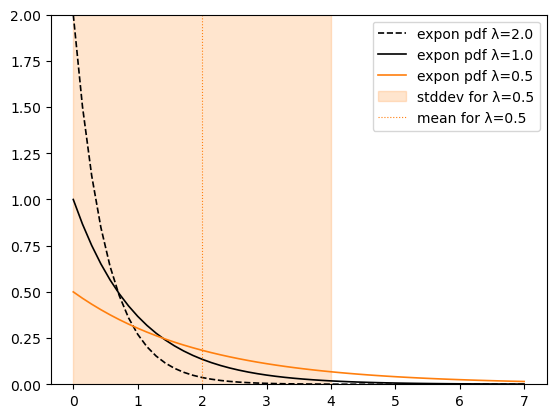

In [2]:
mean, var = stats.expon.stats(moments = 'mv', scale = 2)
std = math.sqrt(var)
# ppf - percent point function (the inverse of a CDF)
# scale is the inverse of the rate λ (so scale is the same as mean for the exponential pdf in scipy.stats)
x = np.linspace(0.0001, 7.0, 50)

fig, ax = plt.subplots(1, 1)
ax.plot(x, stats.expon.pdf(x, scale = 0.5), 'k--', lw=1.2, label='expon pdf λ=2.0')
ax.plot(x, stats.expon.pdf(x, scale = 1), 'k', lw=1.2, label='expon pdf λ=1.0')
ax.plot(x, stats.expon.pdf(x, scale = 2), 'C1-', lw=1.2, label='expon pdf λ=0.5')
plt.fill_between([mean - std, mean + std], y1 = -0.2, y2 = 2.2, color="C1", alpha=0.2, label='stddev for λ=0.5')
plt.axvline(x = mean, color = "C1", linestyle = ":", lw = 0.8, label = 'mean for λ=0.5')
ax.set_ylim(0.0, 2.0)
ax.legend()
plt.show()

* The exponential density function is __positive__ (more precisely, its support is positive)
* Mean is $1/\lambda$ and equals the standard deviation
* (just today) we do not think of Exponential as arrivals.
* The __maximum entropy distribution__ for a random variable which is non-negative and has a fixed expectation:
    * Contains minimum information besides the expected displacement from zero.
    * It fixes the expectation and allows many values that are smaller, and larger.
* This is why it is a natural prior for standard deviation. 
* $\sigma \sim \mathrm{Exponential}(1)$ means we expect the standard deviation to be 1, and now nothing more about it.

<br/><br/><br/><br/><br/><br/><br/><br/>

# Correlation Is Not Causation

* "Correlation in general is not surprising. In large data sets, every pair of variables has a statistically discernible non-zero correlation."
* Example: States with many Waffle Houses per person, like Georgia or Alabama, also have some of the highest divorce rates in the United States.

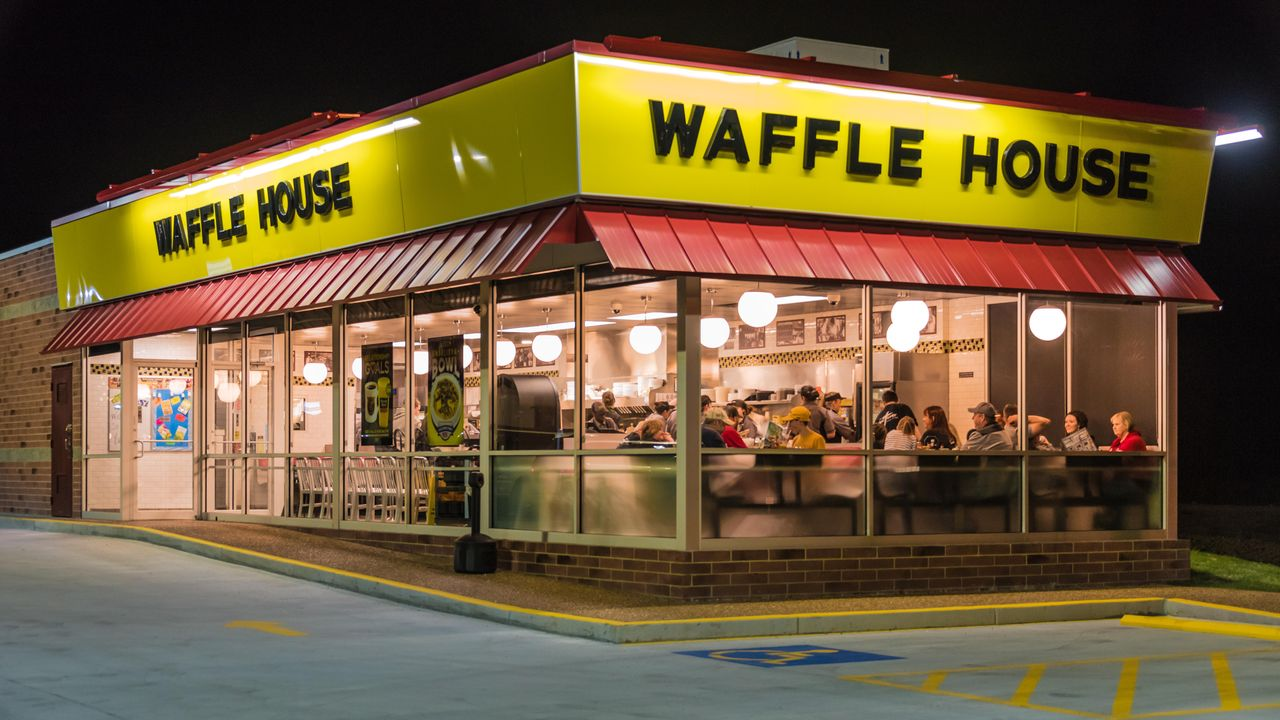

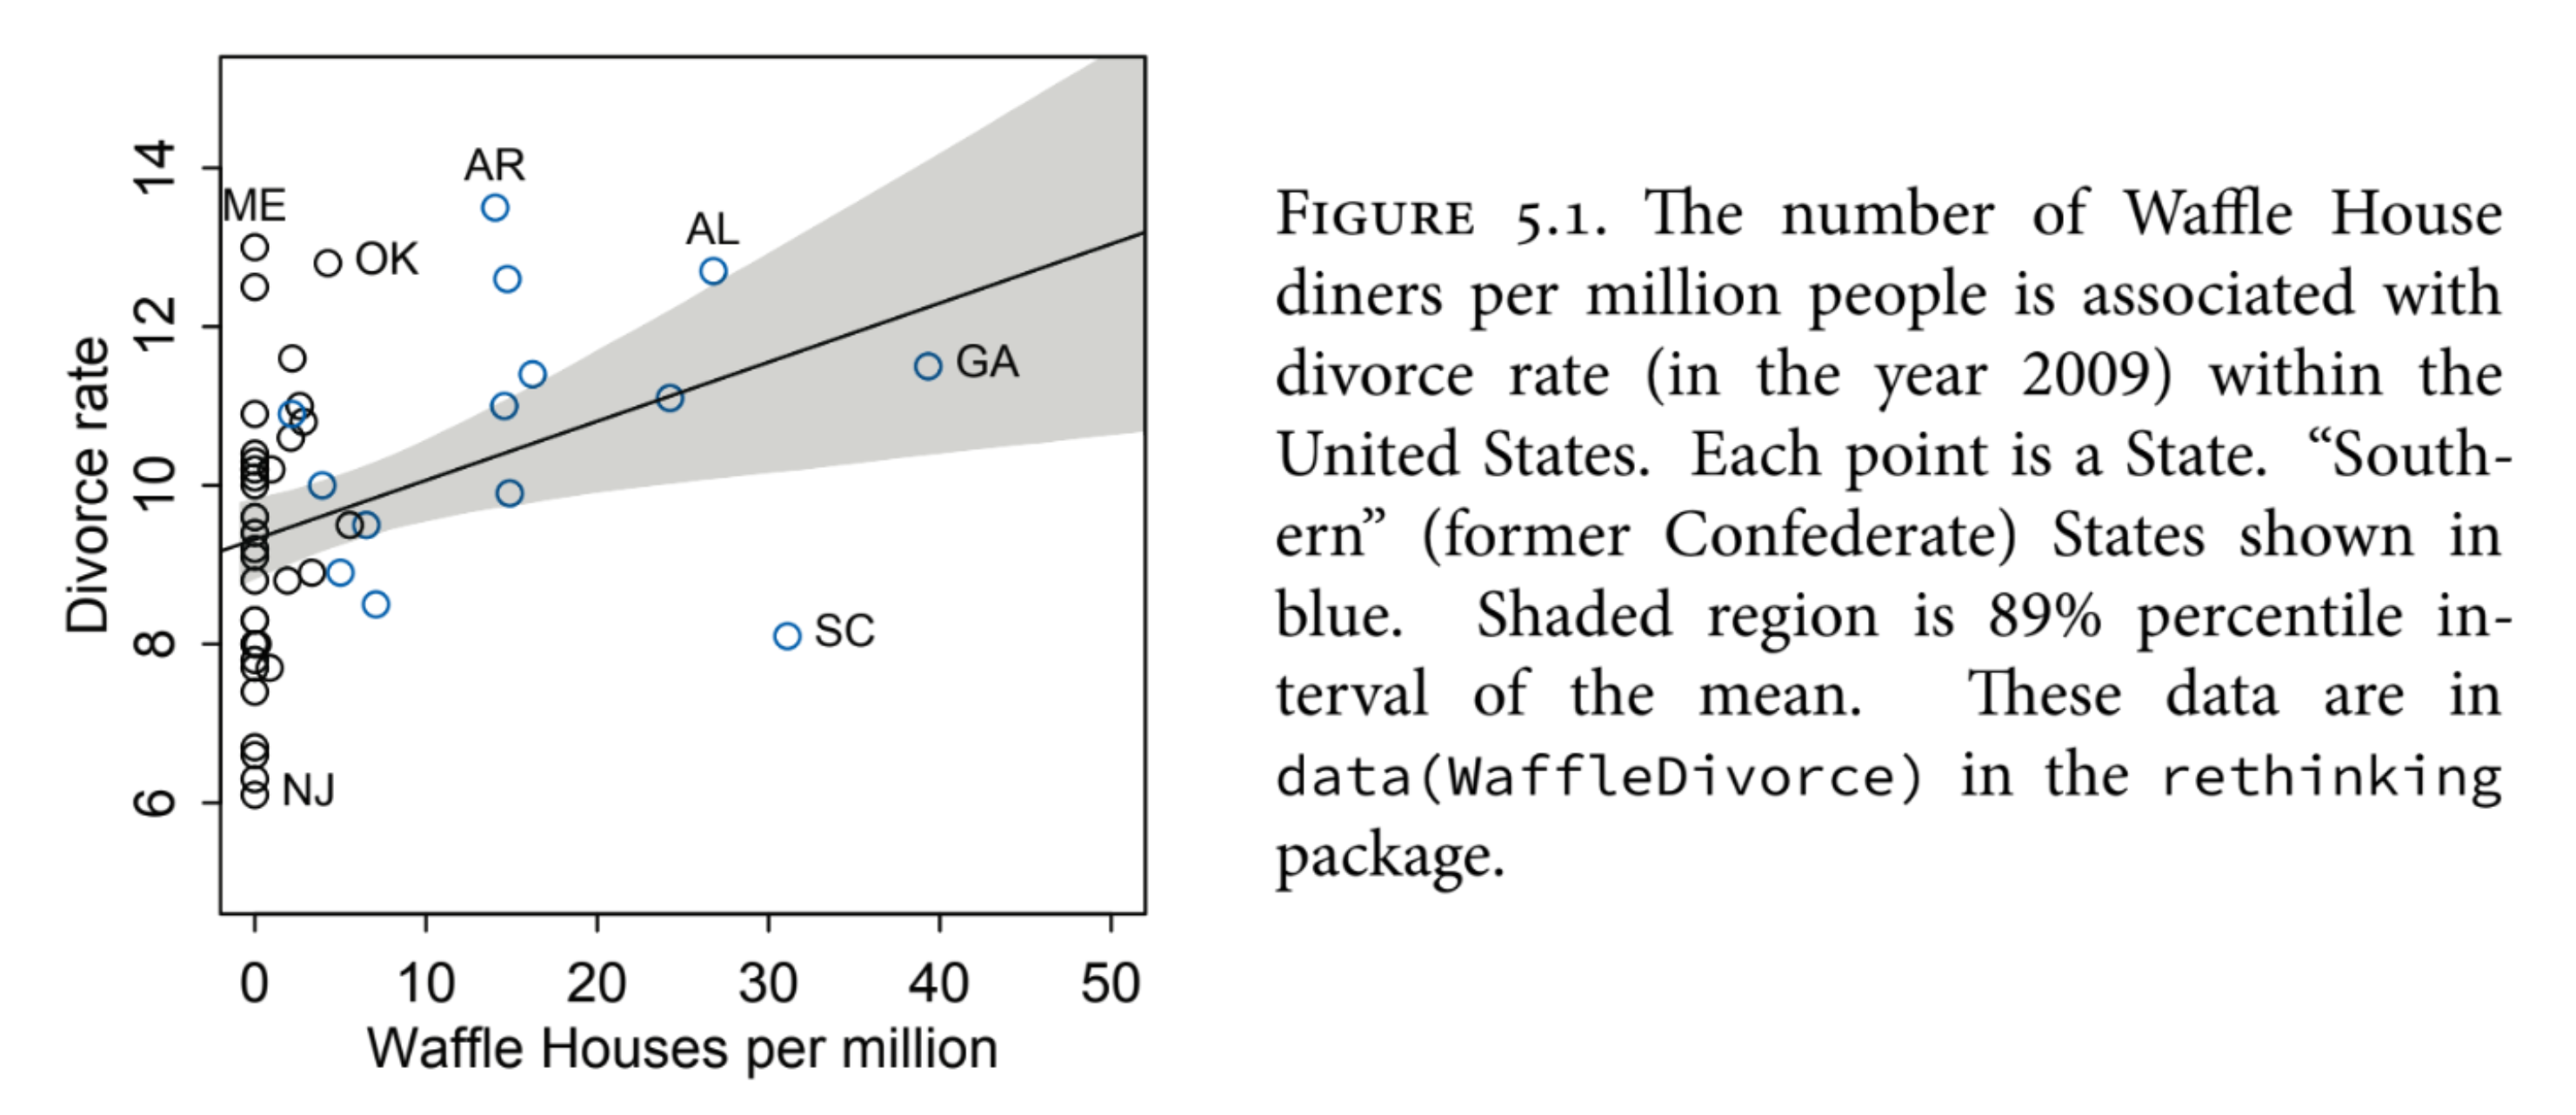

* Probably just an accident of history that Waffle House and high divorce rates both occur in the South.

* Most correlations are no evidence of causation.

* __Multiple regression__ is one instrument we have to uncover suspect correlations.
* __Causal inference__ is another instrument we will employ to inject background knowledge into our inspection of correlations.

<br/><br/><br/><br/><br/><br/><br/><br/>

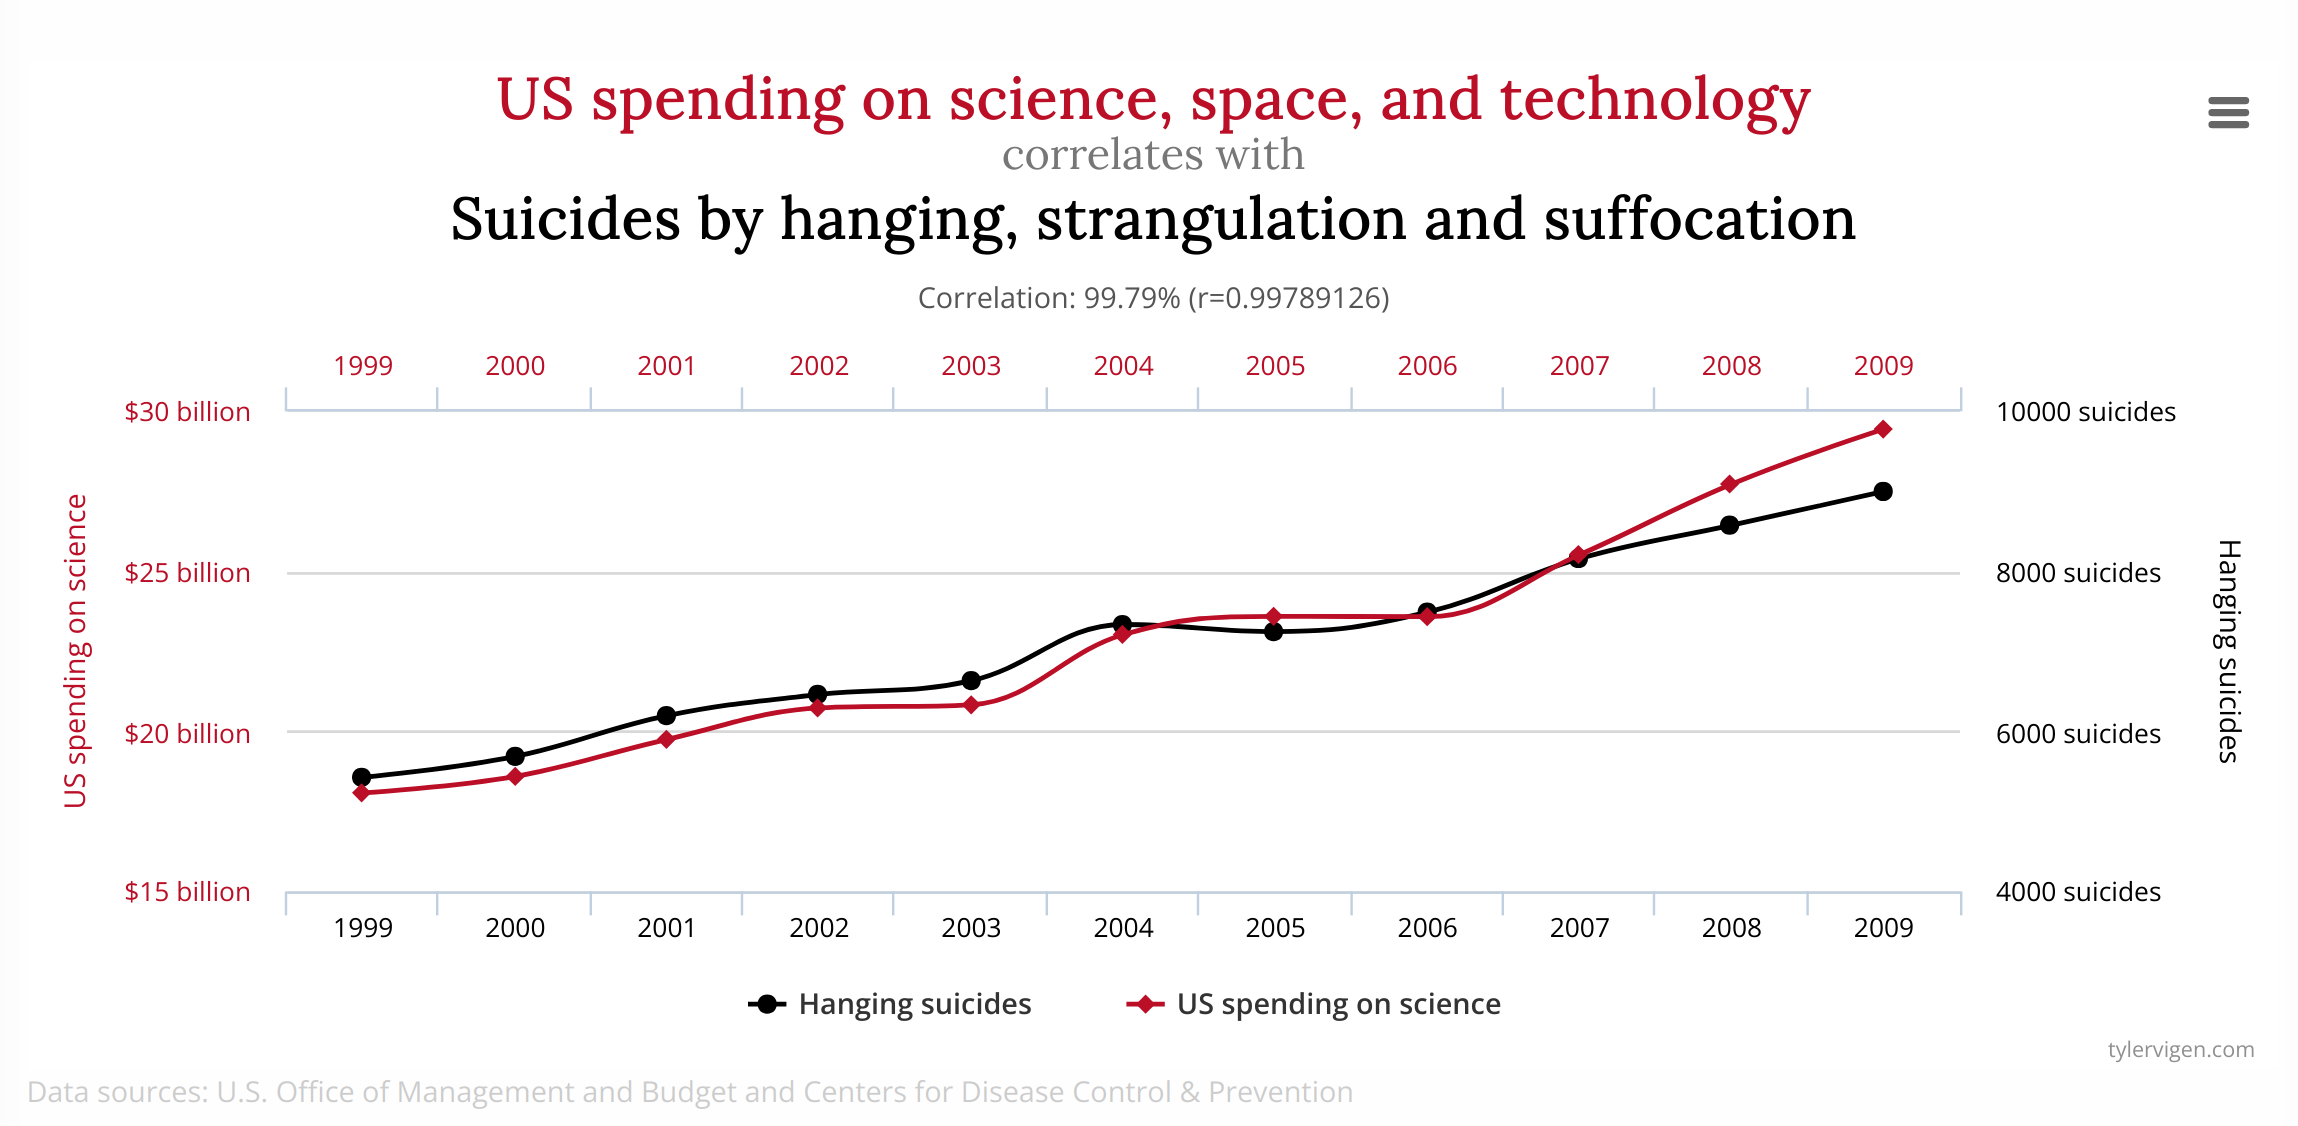

* More insane correlations: https://www.tylervigen.com/spurious-correlations

<br/><br/><br/><br/><br/><br/><br/><br/>

# Two (More Serious) Predictors of Divorce Rate

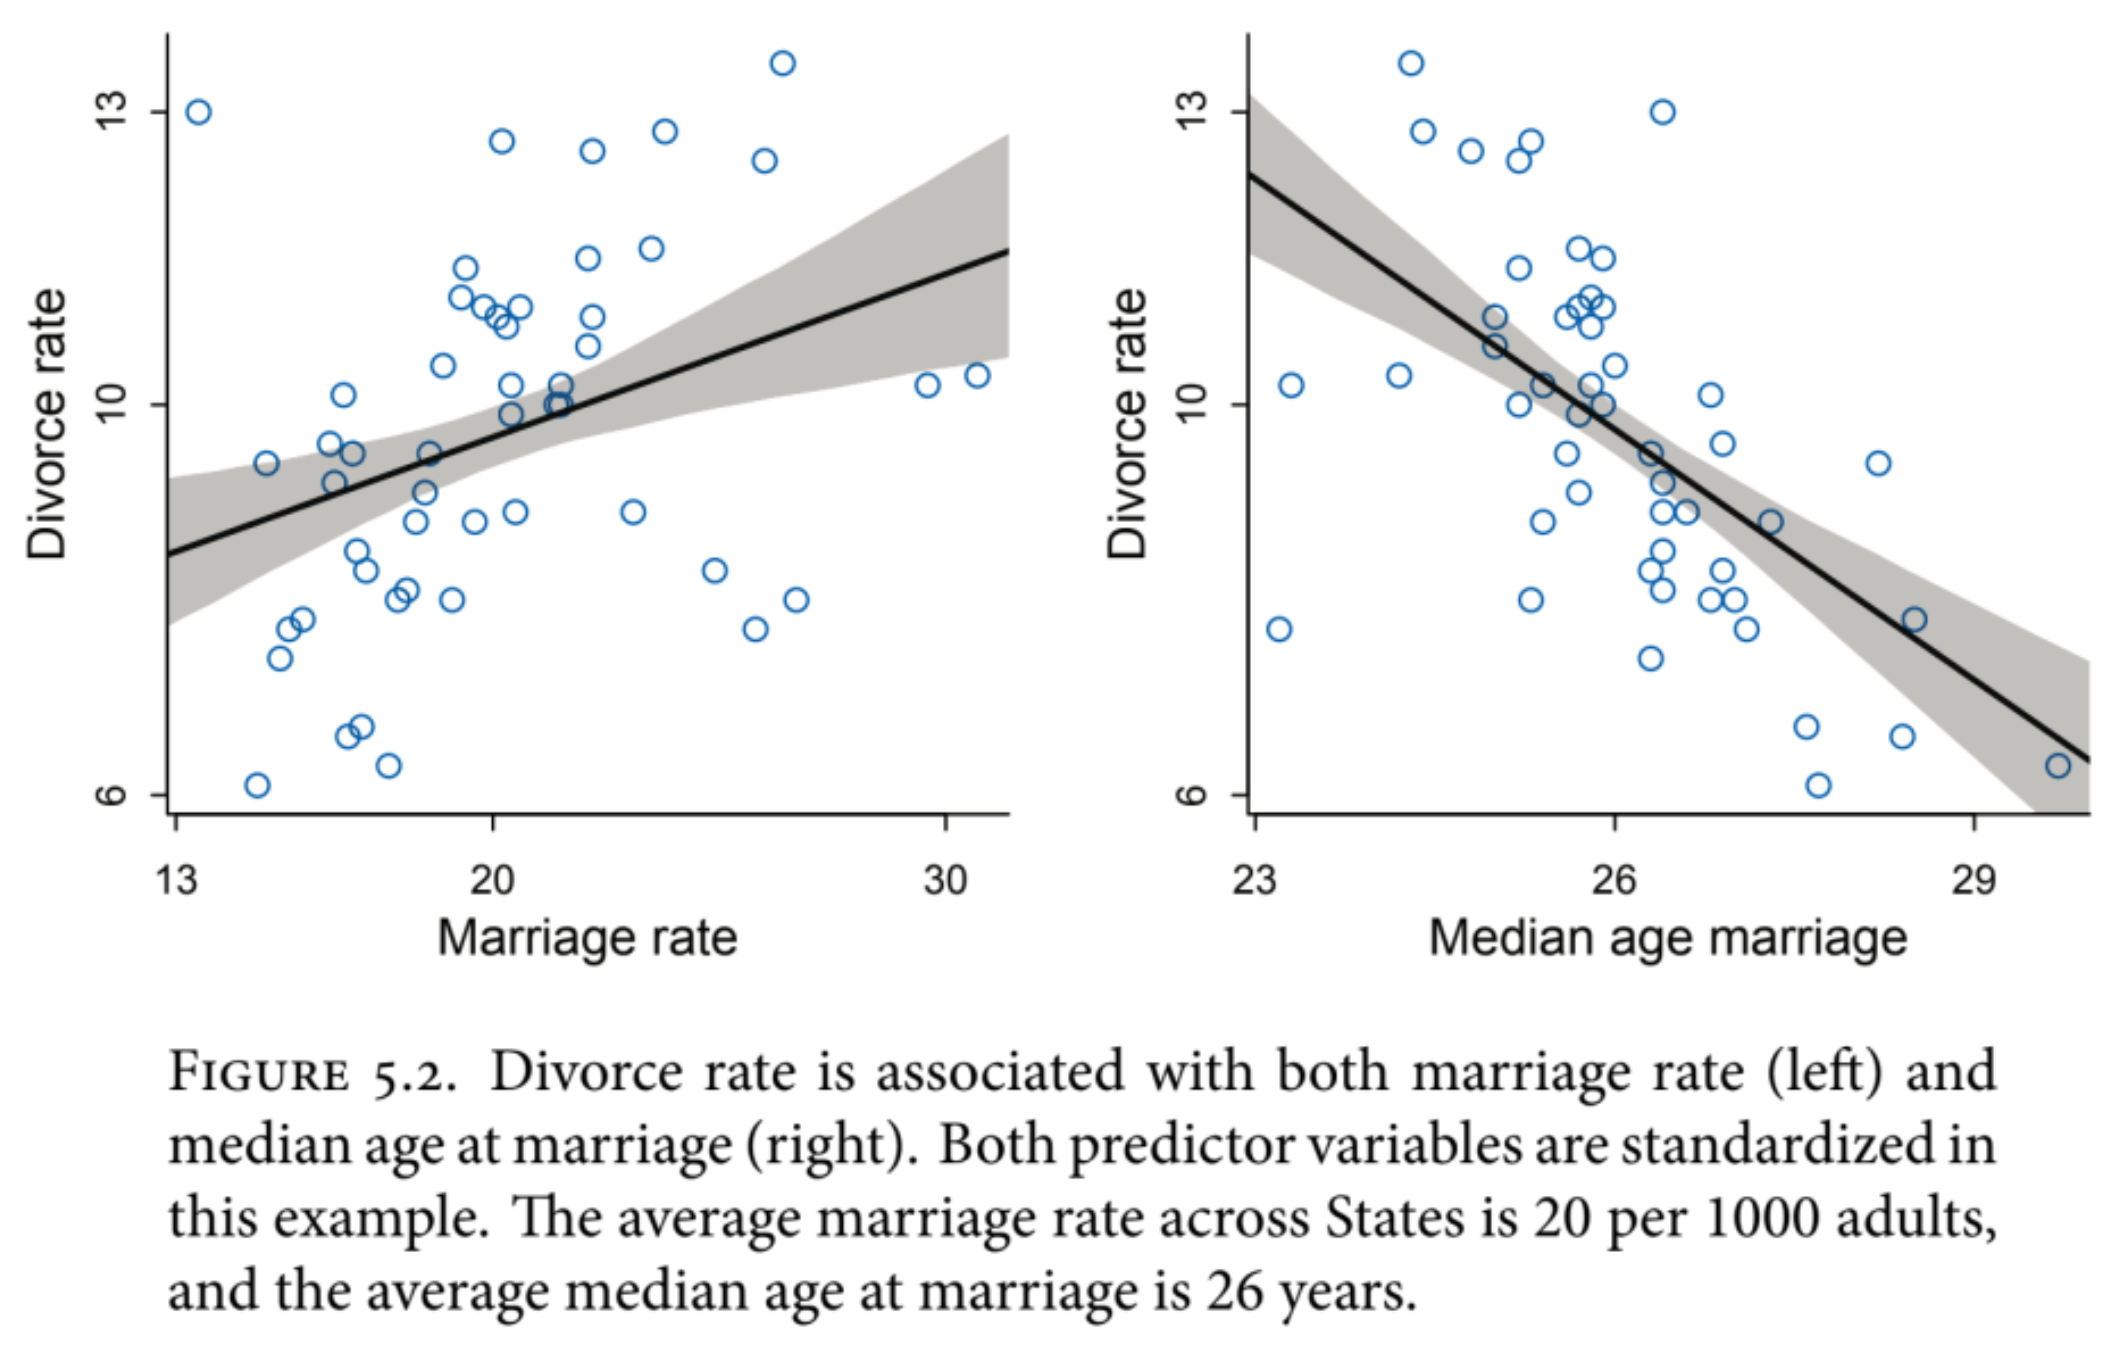


<br/><br/><br/><br/><br/><br/><br/><br/>

Let's load the data:

In [3]:
data = pd.read_csv("WaffleDivorce.csv", delimiter=";").to_xarray()
data.to_dataframe()

Location Loc  Population  MedianAgeMarriage  Marriage  \
index                                                                      
0                   Alabama  AL        4.78               25.3      20.2   
1                    Alaska  AK        0.71               25.2      26.0   
2                   Arizona  AZ        6.33               25.8      20.3   
3                  Arkansas  AR        2.92               24.3      26.4   
4                California  CA       37.25               26.8      19.1   
5                  Colorado  CO        5.03               25.7      23.5   
6               Connecticut  CT        3.57               27.6      17.1   
7                  Delaware  DE        0.90               26.6      23.1   
8      District of Columbia  DC        0.60               29.7      17.7   
9                   Florida  FL       18.80               26.4      17.0   
10                  Georgia  GA        9.69               25.9      22.1   
11                   Hawaii  HI        1.36               26.9      24.9   
12                    Idaho  ID        1.57               23.2      25.8   
13                 Illinois  IL       12.83               27.0      17.9   
14                  Indiana  IN        6.48               25.7      19.8   
15                     Iowa  IA        3.05               25.4      21.5   
16                   Kansas  KS        2.85               25.0      22.1   
17                 Kentucky  KY        4.34               24.8      22.2   
18                Louisiana  LA        4.53               25.9      20.6   
19                    Maine  ME        1.33               26.4      13.5   
20                 Maryland  MD        5.77               27.3      18.3   
21            Massachusetts  MA        6.55               28.5      15.8   
22                 Michigan  MI        9.88               26.4      16.5   
23                Minnesota  MN        5.30               26.3      15.3   
24              Mississippi  MS        2.97               25.8      19.3   
25                 Missouri  MO        5.99               25.6      18.6   
26                  Montana  MT        0.99               25.7      18.5   
27                 Nebraska  NE        1.83               25.4      19.6   
28            New Hampshire  NH        1.32               26.8      16.7   
29               New Jersey  NJ        8.79               27.7      14.8   
30               New Mexico  NM        2.06               25.8      20.4   
31                 New York  NY       19.38               28.4      16.8   
32           North Carolina  NC        9.54               25.7      20.4   
33             North Dakota  ND        0.67               25.3      26.7   
34                     Ohio  OH       11.54               26.3      16.9   
35                 Oklahoma  OK        3.75               24.4      23.8   
36                   Oregon  OR        3.83               26.0      18.9   
37             Pennsylvania  PA       12.70               27.1      15.5   
38             Rhode Island  RI        1.05               28.2      15.0   
39           South Carolina  SC        4.63               26.4      18.1   
40             South Dakota  SD        0.81               25.6      20.1   
41                Tennessee  TN        6.35               25.2      19.4   
42                    Texas  TX       25.15               25.2      21.5   
43                     Utah  UT        2.76               23.3      29.6   
44                  Vermont  VT        0.63               26.9      16.4   
45                 Virginia  VA        8.00               26.4      20.5   
46               Washington  WA        6.72               25.9      21.4   
47            West Virginia  WV        1.85               25.0      22.2   
48                Wisconsin  WI        5.69               26.3      17.2   
49                  Wyoming  WY        0.56               24.2      30.7   

       Marriage SE  Divorce  Divorce SE  WaffleHouses  South  Slav

<br/><br/><br/><br/><br/><br/><br/><br/>

# Data Standardization (1)

**Data standardization**: set mean of the data to zero, by shifting all locations to mean, and set the standard deviation to 1, by dividing all shifted values by the standard deviation.

Standardization is **reversible**.

In [4]:
def standardize(series):
    """Standardize a data series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

<br/><br/><br/><br/><br/><br/><br/><br/>

# Data Standardization (2)

* Standardize both __regressors__ (predictors) and __target__ (the predicted variable)
* This is often done in regression, even more so in multiple linear regression
* Algorithms work better, if all data columns are on the same scale.
* It is easier to select priors for mean and standard deviation.
* After the regression is performed, we can __reverse the standardization__, if want to do predictions. (It is just multiplying by a constant and adding a constant.)

In [5]:
data["Divorce_std"] = standardize(data.Divorce)
data["Marriage_std"] = standardize(data.Marriage)
data["MedianAgeMarriage_std"] = standardize(data.MedianAgeMarriage)

In [6]:
data.to_dataframe().head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
index                                                                         
0         Alabama  AL        4.78               25.3      20.2         1.27   
1          Alaska  AK        0.71               25.2      26.0         2.93   
2         Arizona  AZ        6.33               25.8      20.3         0.98   
3        Arkansas  AR        2.92               24.3      26.4         1.70   
4      California  CA       37.25               26.8      19.1         0.39   

       Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
index                                                                         
0         12.7        0.79           128      1      435080          964201   
1         12.5        2.05             0      0           0               0   
2         10.8        0.74            18      0           0               0   
3         13.5        1.22            41      1      111115          435450   
4          8.0        0.24             0      0           0          379994   

       PropSlaves1860  Divorce_std  Marriage_std  MedianAgeMarriage_std  
index                                                                    
0                0.45     1.671000      0.022874              -0.612445  
1                0.00     1.560044      1.565536              -0.693671  
2                0.00     0.616916      0.049472              -0.206314  
3                0.26     2.114824      1.671927              -1.424706  
4                0.00    -0.936470     -0.269700               0.605947

<br/><br/><br/><br/><br/><br/><br/><br/>

* The regression used to produce the second plot (right in Fig. 5.2):
    
$$D_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_AA_i$$
$$\alpha \sim \mathrm{Normal}(0, 0.2)$$
$$\beta_A \sim \mathrm{Normal}(0, 0.5)$$
$$\sigma \sim \mathrm{Exponential}(1)$$

* Recall that $D_i$, $\mu_i$ mean we have separate parameters for each state, but regression parameters are fixed across states.  This allows to account for noise in regression. 
* Priors: $\alpha$ (intercept) close to zero because of the standardization
* The chapter has a nice discussion of the prior for $\beta_A$ arguing why we expect that the influence of age at marriage should be relatively slow on marriage rate. 
    * __Note__: assigning high density to very steep slopes in the prior is misleading the inference.  We normally do __not__ believe that correlations/regressions are exorbitantly strong.
* In the model below we are cheating a bit, and do not use quadratic approximation, but use MCMC right away
* We first use the model to do a _prior predictive check_ - we investigate the prior shape of the regression lines to see if everything is we expect

In [7]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                a + bA * data.MedianAgeMarriage_std.values)

    # D = Divorce Rate Standardized
    D = pm.Normal("D", mu = mu, sigma = sigma, observed = data.Divorce_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m_5_1_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    m_5_1_idata.extend(pm.sample(random_seed = rng))

Sampling: [D, a, bA, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


<br/><br/><br/><br/><br/><br/><br/><br/>

First, a quick look at the structure of the model (note that the LaTeX below is rendered from the model, not typeset by me):

In [8]:
m_5_1

    a ~ Normal(0, 0.2)
   bA ~ Normal(0, 0.5)
sigma ~ Exponential(f())
   mu ~ Deterministic(f(a, bA))
    D ~ Normal(mu, sigma)

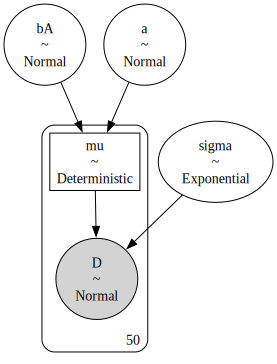

In [9]:
pm.model_graph.model_to_graphviz(m_5_1)

<br/><br/><br/><br/><br/><br/><br/><br/>

Second, what is in the inference data (note a vector of mu's for each state).<br/>
Look into the prior, posterior, and the prior_predictive groups.

In [10]:
m_5_1_idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Let's plot some prior on regression lines

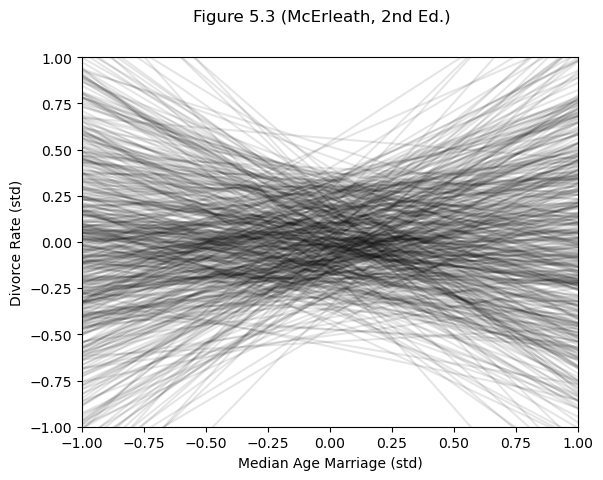

In [11]:
# The index 0 gives us the first chain 
# (there is only one chain for the prior anyway)
a_  = m_5_1_idata.prior.a[0]
bA_ = m_5_1_idata.prior.bA[0]

fig, ax = plt.subplots()
# We use xArray, as multiplication of numpy and pandas does not do what we need
xx  = xr.DataArray(np.linspace(-2, 2, 3), dims="plot_dim")
# xr does some weird matching, but effectively plus is pointwise 
# and multiplication is bA_.T * xx (so matrix multiplication with the first argument transposed)
# We get an array of rows (one per sample from the prior) and the rows contain the three points 
# (the size of xx)
yy  = a_ + bA_ * xx
# transpose yy, because matplotlib wants it this way.
ax.plot(xx, yy.T, c = "k", alpha = 0.1)
    
ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
ax.set_ylim(-1.0, 1.0)
ax.set_xlim(-1.0, 1.0)
fig.suptitle("Figure 5.3 (McErleath, 2nd Ed.)");

* This does not look too bad. Very steep lines would be suspicious, but we seem to still allow a decent range.
* Standard deviation of Median Age Marriage across state is 1.24363 (strange that numpy and the book differ in this assessment; probably a difference between the sample standard deviation and population standard deviation)

In [12]:
data.MedianAgeMarriage.values.std()

1.231131187160816

* This means that a deviation in median age at marriage by 1.2 year would cause one standard deviation in divorce rate.
* This seems unlikely that such a small change would have such a big impact, so we do allow some steep lines (we are not overly conservative).   

<br/><br/><br/><br/><br/><br/><br/><br/>

Let's plot the posterior, so that you have a way in PyMC to make plots like in the book.

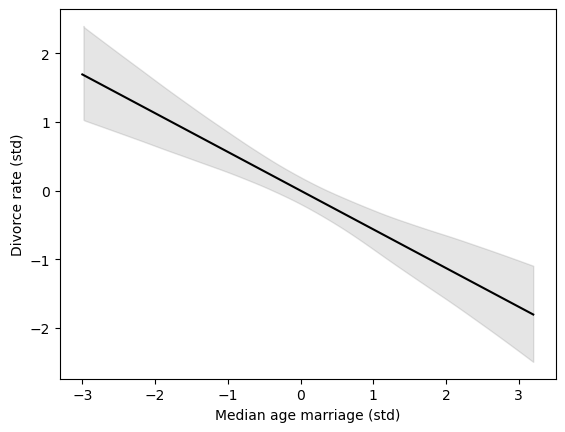

In [13]:
# We use xArray, as multiplication of numpy and pandas does not do what we need
age_std_seq = xr.DataArray(np.linspace(-3, 3.2, 30), dims="plot_dim")

a_ = m_5_1_idata.posterior.a
bA_ = m_5_1_idata.posterior.bA
mu_pred = a_ + bA_ * age_std_seq

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred, fill_kwargs = hdi_fill_args)

# Take average prediction of mu for every point in age_std_seq 
# and plot it as a line
mu_mean = mu_pred.mean(dim='draw')
plt.plot(age_std_seq, mu_mean[0], color="k")

ax.set_xlabel("Median age marriage (std)")
ax.set_ylabel("Divorce rate (std)")
plt.show()

The other posterior plot can be made similarly

<br/><br/><br/><br/><br/><br/><br/><br/>

In [14]:
# Model m_5_2 for completeness, we skip in the lecture
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1.0)
    
    # Note the "deterministic" distribution node, 
    # that basically encodes equality from the mathematical model
    mu = pm.Deterministic("mu", 
                a + bM * data.Marriage_std.values)

    # D = Divorce Rate Standardized
    D = pm.Normal("D", mu = mu, sigma = sigma, observed = data.Divorce_std.values)
    
    # prior predictive is a distribution of data 
    # (but for each data point we also get its parameters so we can plot various regression lines we are getting)
    m_5_2_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    
    # idata stands for 'inference data'. Each sampler returns its own inference data object, and there is no serious need
    # to mix them.  For convenience we use the extend method, to keep all samples in one object.
    m_5_2_idata.extend(pm.sample(random_seed = rng))

Sampling: [D, a, bM, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<br/><br/><br/><br/><br/><br/><br/><br/>

# Which of the two correlations is more important?

* These regressions (both left and right, in the figure above) show some __correlation__.
* When we have two corelations we cannot compare which one is 'better' just by looking at their tightness.
* They could be influencing each other. Perhaps:

    a) Age-At-Marriage (**A**) has a direct impact on Divorce Rate (**D**) as people have longer time to grow incompatible with their partner

    b) Marriage Rate (**M**) has a direct impact on Divorce Rate (**D**) for obvious reason (more marriages => more divorce)

    c) Age-At-Marriage (**A**) has an impact on the Annual Marriage Rate (**M**) because there are more young people (people die => they don't get married)
    
* Here is a DAG representing such causations:

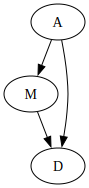

In [15]:
CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[
        ("A", "M"), 
        ("A", "D"), 
        ("M", "D"),
    ]
).draw()

Can A influence D both directly and indirectly???

<br/><br/><br/><br/><br/><br/><br/><br/>

But maybe **A** influences **D** directly, but not really via **M**.  
A causal DAG representing this situation:

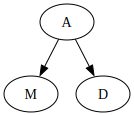

In [16]:
CausalGraphicalModel(
    nodes=["A", "M", "D"],
    edges=[
        ("A", "M"), 
        ("A", "D"), 
    ]
).draw()

This graph would also give us both correlations from Fig. 5.2, because **M** correlates with **D** via a common factor, called a _confounding_ factor.

<br/><br/><br/><br/><br/><br/><br/><br/>

# Conditional (in)Dependencies Discern Causal Scenarios

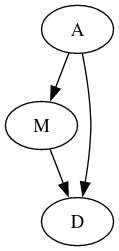&nbsp;&nbsp;&nbsp;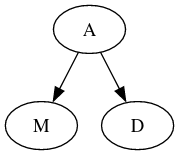

* How can we compare these two graphs?
* Causal graphs are assumptions made by the analyst. But data can be used to **disprove** some assumptions.
* We can see what __conditional independences__ they imply and test for them.
* In the left graph, __every pair of variables is correlated__ (there is an arrow between every pair)
    * $ D \not\!\perp\!\!\!\perp A $, $ D \not\!\perp\!\!\!\perp M$, and $A \not\!\perp\!\!\!\perp M$
    * $\not\!\perp\!\!\!\perp$ means _'not independent'_ or _'dependent'_
* If any pair of columns in the data is independent, then we could disprove (invalidate) this graph
* In the second graph M and D become indpendent if we condition on A
  * once you fix A, all its influence is embedded in M and D and no longer affects their variability as common cause
  * $D \!\perp\!\!\!\perp M \mid A$
  * This reads as _'D conditionally independent of M given A'_
* This is also something we can test in data, if it does not hold, then the diagram can be eliminated.

<br/><br/><br/><br/><br/><br/><br/><br/>

# Multiple Regression (Multivariate Regression) to the Rescue

* Multiple regression can help to uncover such (conditional) (in)dependencies.
    
$$D_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_MM_i + \beta_AA_i$$
$$\alpha \sim \mathrm{Normal}(0, 0.2)$$
$$\beta_A \sim \mathrm{Normal}(0, 0.5)$$
$$\beta_M \sim \mathrm{Normal}(0, 0.5)$$
$$\sigma \sim \mathrm{Exponential}(1)$$

* Note that any of the regression co-efficients being zero, denotes **independence**
* We can fit this model as the others, but we have a problem with plotting. Our regression is a 2D plane in 3D space. 
* In general, impossible to plot these regressions, but we can start with descriptive stats.

<br/><br/><br/><br/><br/><br/><br/><br/>

In [17]:
with pm.Model() as m_5_3:
    a  = pm.Normal("a",  0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", 
        a + bM * data.Marriage_std.values + bA * data.MedianAgeMarriage_std.values)

    D = pm.Normal("D", mu = mu, sigma = sigma, observed=data.Divorce_std.values)
    m_5_3_idata = pm.sample_prior_predictive(samples = 500, random_seed = rng)
    m_5_3_idata.extend(pm.sample(random_seed = rng))

Sampling: [D, a, bA, bM, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


<br/><br/><br/><br/><br/><br/><br/><br/>

# Sanity Checks of the Model

In [18]:
m_5_3

    a ~ Normal(0, 0.2)
   bA ~ Normal(0, 0.5)
   bM ~ Normal(0, 0.5)
sigma ~ Exponential(f())
   mu ~ Deterministic(f(bA, a, bM))
    D ~ Normal(mu, sigma)

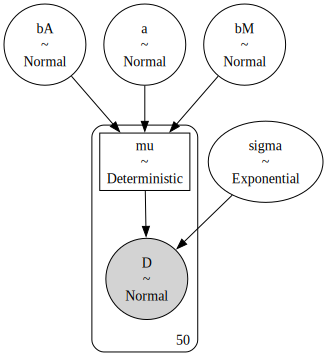

In [19]:
pm.model_graph.model_to_graphviz(m_5_3)

In [20]:
m_5_3_idata # prior, prior predictive, and posterior

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

<br/><br/><br/><br/><br/><br/><br/><br/>

# Causality Analysis with the Posterior

In [21]:
print(rt.precis(m_5_3_idata.posterior)) # bookstyle

sample: 1000 values of 5 variables
         mean    sd    5.5%    94.5%  histogram
a        0.00  0.10   -0.16     0.16  ▁▁▂▇█▄▁▁
bA      -0.61  0.16   -0.86    -0.36  ▁▁▂▅█▅▂▁
bM      -0.06  0.16   -0.32     0.19  ▁▁▂▅█▅▂▁
sigma    0.83  0.09    0.71     0.98  ▁▄█▆▃▁▁▁
mu       0.00  0.60   -1.04     0.88  ▁▁▁▂█▄▁▁


In [22]:
az.summary(m_5_3_idata, group="posterior", var_names=["a", "bM", "bA", "sigma"], kind="stats") # arviz style

mean     sd  hdi_3%  hdi_97%
a      0.001  0.101  -0.191    0.187
bM    -0.063  0.162  -0.348    0.249
bA    -0.609  0.159  -0.905   -0.312
sigma  0.833  0.086   0.684    1.001

Here we have a comparison of univariate and multivariate slopes for these predictors:

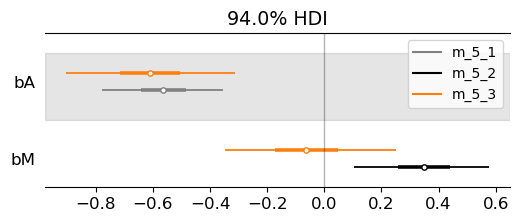

In [23]:
# Create the forest plot
az.plot_forest(
    data = [m_5_3_idata, m_5_2_idata, m_5_1_idata], 
    model_names = ["m_5_3", "m_5_2", "m_5_1"], 
    colors = ["C1", "k","gray"],
    kind = 'forestplot',
    # kind = 'ridgeplot',  # try ridgeplot instead for more information 
    var_names=["bA","bM"], 
    hdi_prob=0.94, 
    combined = True, # plots the result for all four chains combined (try False)
    ridgeplot_alpha = .6,
    figsize = (6,2), 
    textsize = 12)

# Add the reference decision point (no influence: 0)
plt.axvline(x = 0.0, color = 'k', lw = 1, alpha = 0.3)
plt.show()


* In the multivariate model (`m_5_3`) the posterior rate for bM is close to zero, while bA is almost unchanged comparing to `m_5_1`.
* This indicates that the influence from M to D is minimal
* _"Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that state."_
* So $D \!\perp\!\!\!\perp M \mid A$ and the second causal graph (with two edges) is more likely
* __This is crazy: we used correlation analysis to decide something about causation!__ And purely based on data!

<br/><br/><br/><br/><br/><br/><br/><br/>

# Residual Plots (Time Permitting)
* They visualize the "added value/information" of each predictor with respect to the other.

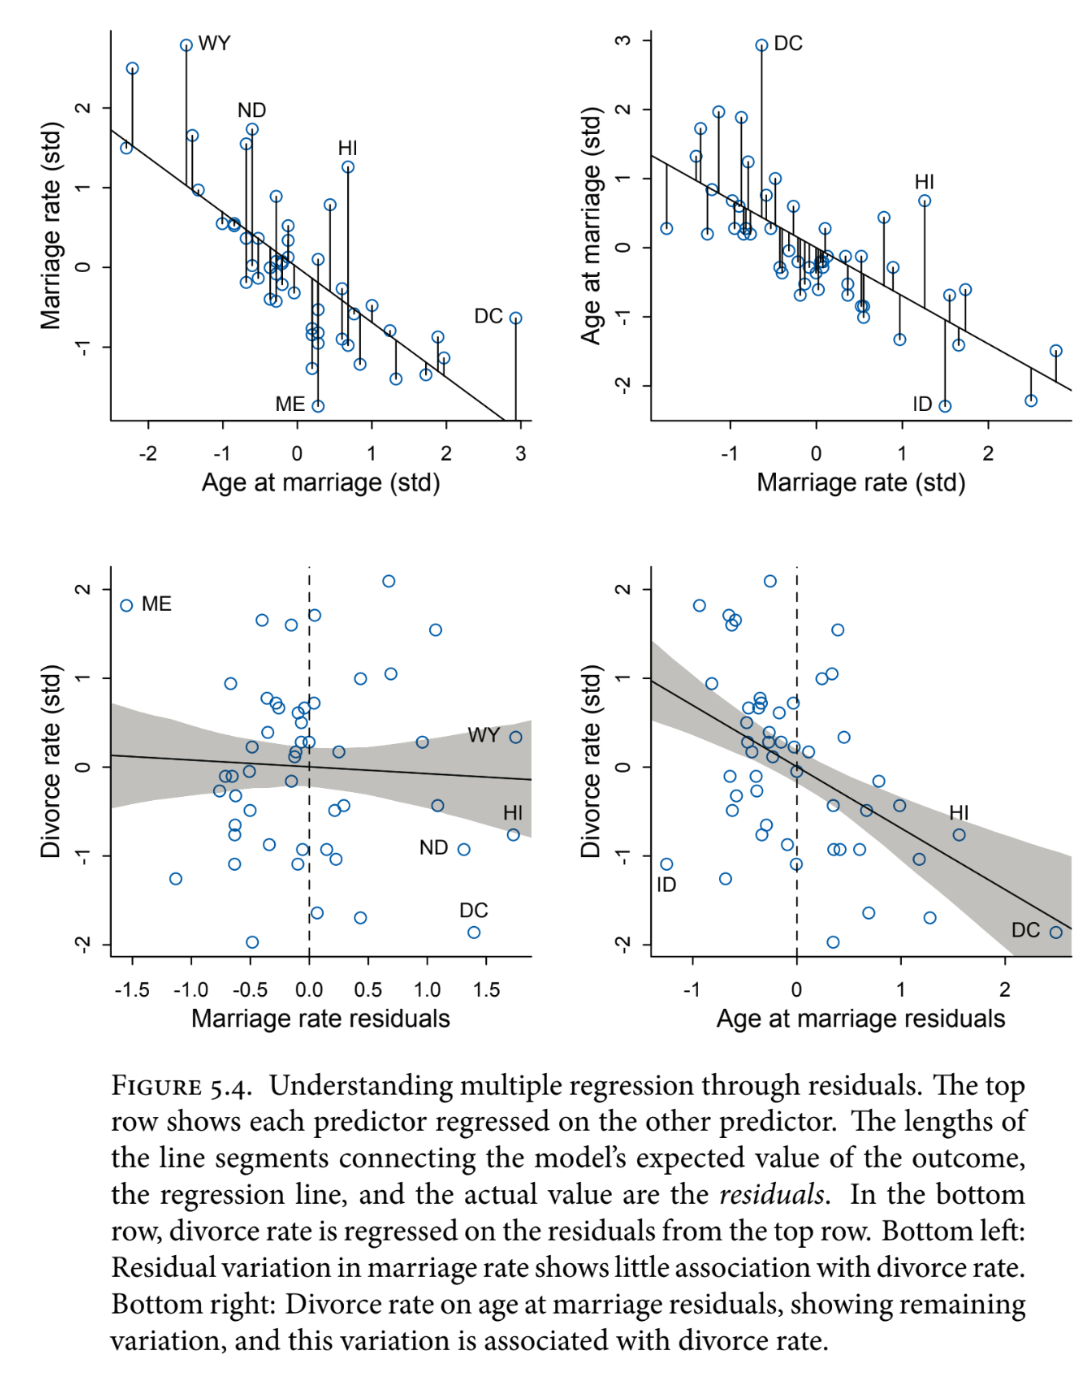

<br/><br/><br/><br/><br/><br/><br/><br/>

# Posterior Predictive Plot (Time Permitting)

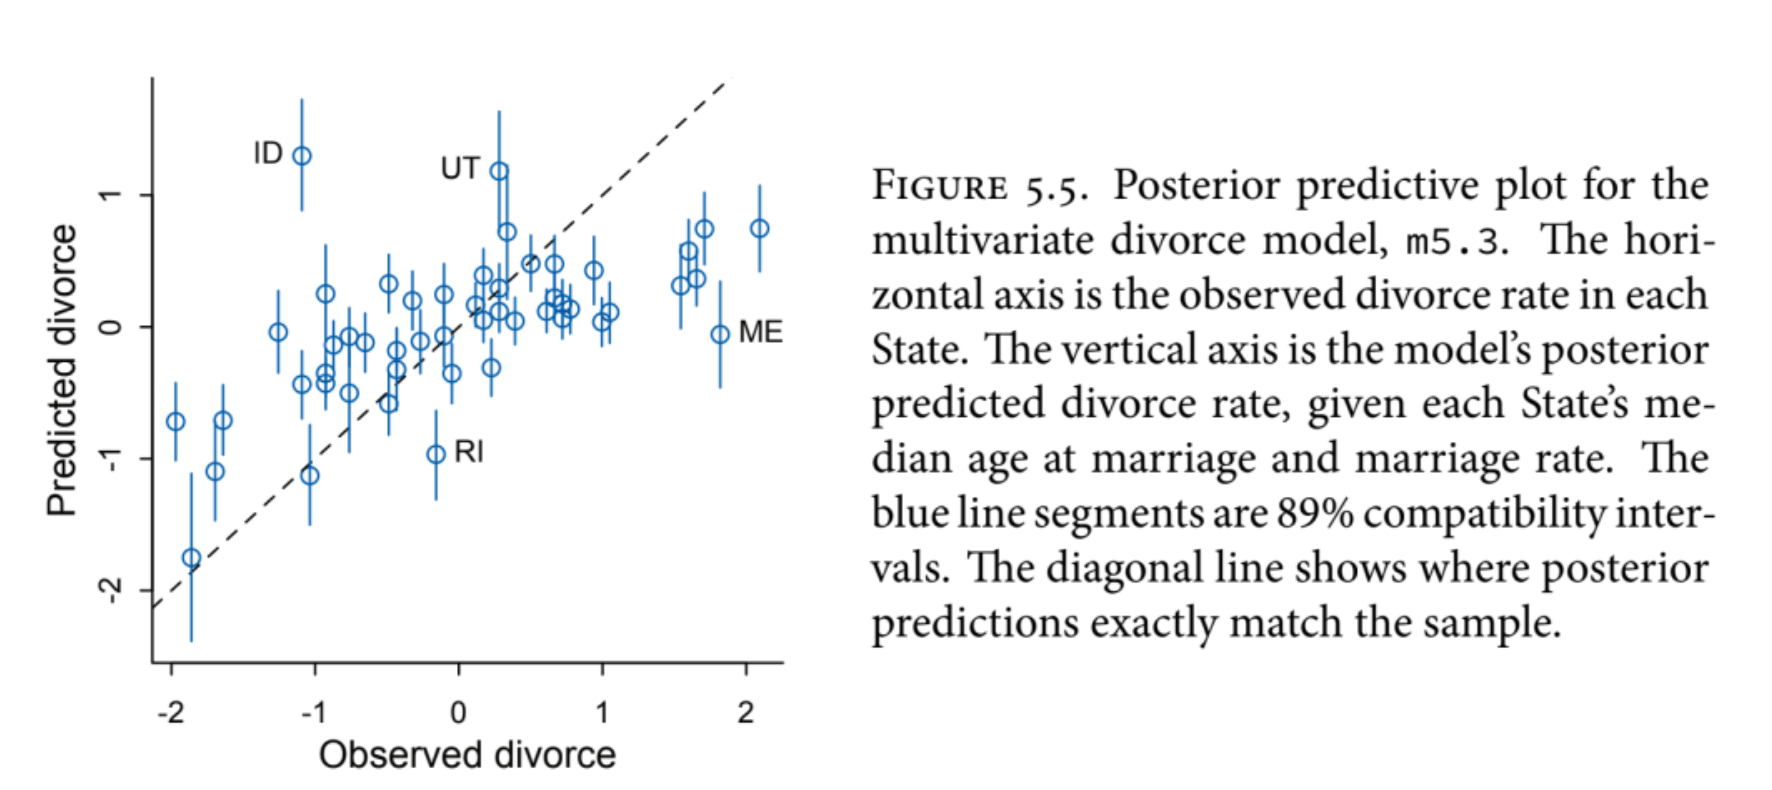

<br/><br/><br/><br/><br/><br/><br/><br/>

# Counterfactuals

* Display causal implications in the model, explore **interventions** theoretically, before execution
* __Counterfactual__ --- the name stands from the fact that we use new values of predictors, __not the factual ones__
* (for instance unobserved combinations like very high median age at marriage with very high marriage rate)
* _"What would Utah's divorce rate be,if it's median age-at-marriage were higher?"_ 
  - (with everything else we otherwise know from the model)
* Allows to __understand the model__ effect of a certain predictor
* __An intervention:__ pay young couples to postpone marriage until they are 35 yo
* This will also decrease marriage rate (some will die, etc).
* Intuitions: **Counterfactuals** are **predictions** but down with a causal model, not just the corelation model
  - (so they embed our causal assumptions as well). 

**How?**
1. Pick a variable to manipulate (the intervention variable)
2. Define the range of values to set the intervention variable to
3. For each sample in the posterior use the casual model to simulate the values of other variables, including the outcome.

<br/><br/><br/><br/><br/><br/><br/><br/>

# Counterfactual Plots (Example)

Let's do this for: 

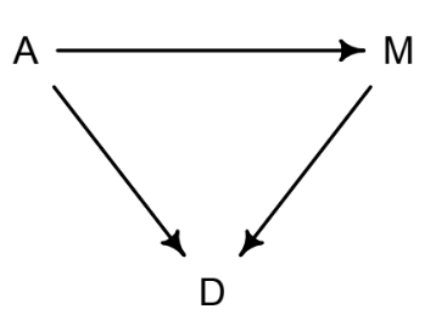

* We are using our last multi-variate model, but it did not include influence of A on M.
* We add a regression of A on M as well with new parameters bAM and aM below.

In [24]:
with pm.Model() as m5_3_A:

    # mutable data nodes
    M = pm.MutableData("M", data.Marriage_std.values, dims = "marriage_obs_id")
    A = pm.MutableData("A", data.MedianAgeMarriage_std.values, dims="age_obs_id")
    D = pm.MutableData("D", data.Divorce_std.values, dims = "divorce_obs_id")
    
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA    = pm.Normal("bA", 0, 0.5)
    bM    = pm.Normal("bM", 0, 0.5)
    a     = pm.Normal("a", 0, 0.2)
    
    mu = pm.Deterministic("mu", a + bA * A + bM * M)
    divorce  = pm.Normal("divorce", mu, sigma, observed = D)

    # A -> M
    sigmaM = pm.Exponential("sigmaM", 1)
    bAM    = pm.Normal("bAM", 0, 0.5)
    aM     = pm.Normal("aM", 0, 0.2)
    
    muM = pm.Deterministic("muM", aM + bAM * A)
    marriage = pm.Normal("marriage", muM, sigmaM, observed = M)

    m5_3_A_idata = pm.sample(random_seed = rng)

/home/wasowski/miniconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigmaM, bAM, aM]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


<br/><br/><br/><br/><br/><br/><br/><br/>

In [25]:
m5_3_A

   sigma ~ Exponential(f())
      bA ~ Normal(0, 0.5)
      bM ~ Normal(0, 0.5)
       a ~ Normal(0, 0.2)
  sigmaM ~ Exponential(f())
     bAM ~ Normal(0, 0.5)
      aM ~ Normal(0, 0.2)
      mu ~ Deterministic(f(bM, a, bA))
     muM ~ Deterministic(f(aM, bAM))
 divorce ~ Normal(mu, sigma)
marriage ~ Normal(muM, sigmaM)

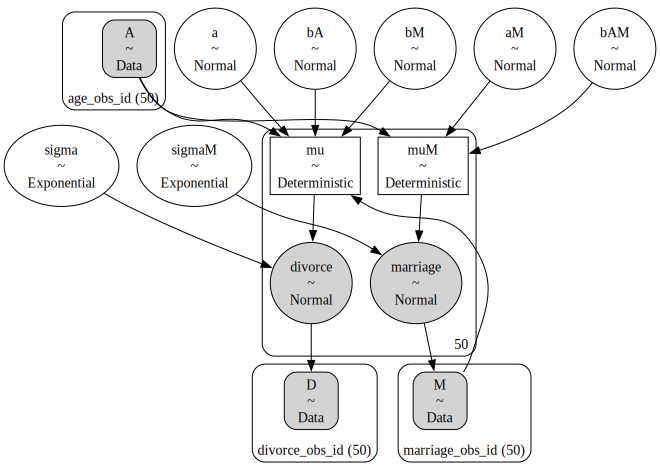

In [26]:
pm.model_graph.model_to_graphviz(m5_3_A)

<br/><br/><br/><br/><br/><br/><br/><br/>

We plot this the same way as posterior predictions last week, by replacing the predictors with a new set of values of interest.  
The range of values of A  (imaginary interventions)

In [27]:
A_seq = np.linspace(-2, 2, 42)

In [28]:
# With PyMC3 we have to simulate in each model separately

with m5_3_A:
    # We use parameters learned from the posterior, 
    # but use it to predict results for a new range of Age values.
    pm.set_data({ "A": A_seq, "M": np.zeros_like(A_seq), "D": np.zeros_like(A_seq) }) 
    pm.sample_posterior_predictive(
        m5_3_A_idata, 
        predictions = True, 
        extend_inferencedata = True, 
        #var_names=['M','D'],
        random_seed = rng
    )

Sampling: [divorce, marriage]


Output()

<br/><br/><br/><br/><br/><br/><br/><br/>

The model gives a sample (distribution) of values of other variables using the posterior

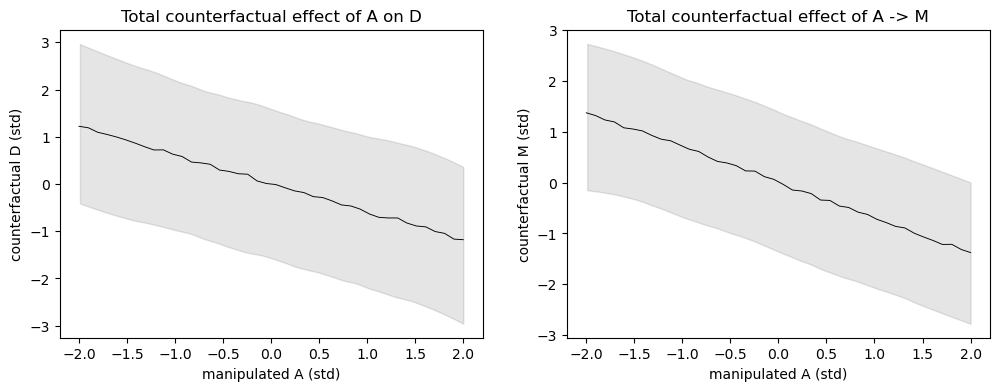

In [29]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_A_idata.predictions.divorce, ax=ax[0], fill_kwargs = hdi_fill_args)
ax[0].plot(A_seq, m5_3_A_idata.predictions.divorce[0].mean(axis=0), 'k', lw = .66)

ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A (std)")
ax[0].set_ylabel("counterfactual D (std)")

az.plot_hdi(A_seq, m5_3_A_idata.predictions.marriage, ax=ax[1], fill_kwargs = hdi_fill_args)
ax[1].plot(A_seq, m5_3_A_idata.predictions.marriage[0].mean(axis=0), 'k', lw = .66)
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A (std)")
ax[1].set_ylabel("counterfactual M (std)");

<br/><br/><br/><br/><br/><br/><br/><br/>

# Masked Relationship

* We have so far detect a __spurious association__
* Another problem is that influence can also be __masked__ (hidden) by existance of some other variable/feature
* When you have two correlated variables, but one influences the target negative and the other positively, if you don't separate them, you may see no effect.

<br/><br/><br/><br/><br/><br/><br/><br/>

# An Example

* **Case Study**: Composition of milk in primate species, in particular, especially given body mass and brain size

* We want to regress `kcal.per.g` (kilocalories of energy per gram of milk, $K$)
* Against `mass` (average female body mass in kg, $M$) and `neocortex.perc` (percent of total brain mass that is neocortex mass, $N$).

In [30]:
d = pd.read_csv("milk.csv", delimiter=";").to_xarray()
# standardize regressors and the target
d["K"] = standardize(d['kcal.per.g'])
d["N"] = standardize(d['neocortex.perc'])
d["M"] = standardize(d['mass'])

# data complete cases (drop index rows containing N/As)
dcc = d.dropna('index')
dcc

<xarray.Dataset> Size: 2kB
Dimensions:         (index: 17)
Coordinates:
  * index           (index) int64 136B 0 5 6 7 9 10 11 ... 19 21 23 24 26 27 28
Data variables:
    clade           (index) object 136B 'Strepsirrhine' ... 'Ape'
    species         (index) object 136B 'Eulemur fulvus' ... 'Homo sapiens'
    kcal.per.g      (index) float64 136B 0.49 0.47 0.56 0.89 ... 0.48 0.55 0.71
    perc.fat        (index) float64 136B 16.6 21.22 29.66 ... 21.18 36.84 50.49
    perc.protein    (index) float64 136B 15.42 23.58 23.46 ... 11.68 9.54 9.84
    perc.lactose    (index) float64 136B 67.98 55.2 46.88 ... 67.14 53.62 39.67
    mass            (index) float64 136B 1.95 5.25 5.37 ... 40.74 33.11 54.95
    neocortex.perc  (index) float64 136B 55.16 64.54 64.54 ... 70.24 76.3 75.49
    K               (index) float64 136B -0.9567 -1.083 ... -0.5784 0.4305
    N               (index) float64 136B -2.144 -0.5243 -0.5243 ... 1.507 1.367
    M               (index) float64 136B -0.5249 -0.3894 ... 0.7553 1.653

<br/><br/><br/><br/><br/><br/><br/><br/>

# Masked Interactions (Example, Regression Model)
(Building a model, inferring a posterior, analyzine the result of regression))

* But let us just start with `Neocortext.perc` (a single regressor)

$$K_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta_N N_i$$
$$\ldots$$

* (again there is a good part in the chapter about priors)

In [31]:
with pm.Model() as m5_5:
    N_mut = pm.MutableData("N_mut", dcc.N.values)
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * N_mut)

    K = pm.Normal("K", mu, sigma, observed = dcc.K)

    m5_5_trace = pm.sample(random_seed = rng)

/home/wasowski/miniconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


<br/><br/><br/><br/><br/><br/><br/><br/>

In [32]:
m5_5

sigma ~ Exponential(f())
   bN ~ Normal(0, 0.5)
    a ~ Normal(0, 0.2)
   mu ~ Deterministic(f(a, bN))
    K ~ Normal(mu, sigma)

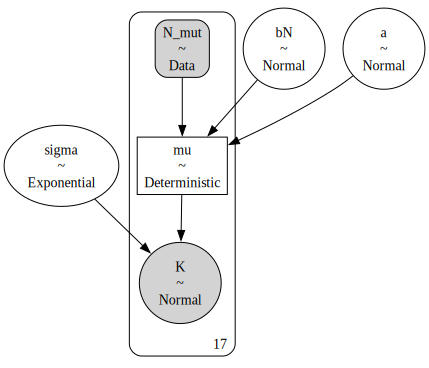

In [33]:
pm.model_graph.model_to_graphviz(m5_5)

In [34]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"], kind = 'stats')

mean     sd  hdi_3%  hdi_97%
a      0.036  0.157  -0.258    0.322
bN     0.123  0.240  -0.307    0.583
sigma  1.127  0.209   0.773    1.518

* the association seems very weak from N (neocortext size) to K (energy in milk)
* the plot below confirms it

In [35]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 33)

with m5_5:
    pm.set_data({"N_mut": xseq}) 
    pm.sample_posterior_predictive(
        m5_5_trace, 
        var_names=["mu"],
        predictions = True,
        extend_inferencedata = True
    )

Sampling: []


Output()

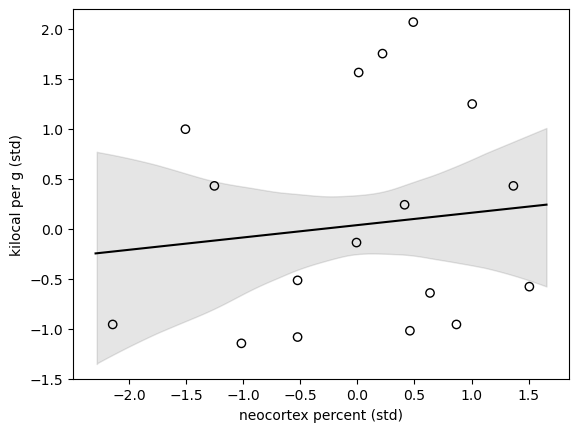

In [36]:
mu_mean = m5_5_trace.predictions.mu.mean('draw').sel(chain=0).values
fig, ax = plt.subplots()
az.plot_hdi(xseq, m5_5_trace.predictions.mu, ax = ax, fill_kwargs = hdi_fill_args)
ax.plot(xseq, mu_mean, c = "black")
ax.scatter(dcc.N, dcc.K, facecolors = "none", edgecolors = "k")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

* We also look at log body mass and it is not particularly strong either 
    * log, because we believe that the correlation is rather with the order of magnitude for weight

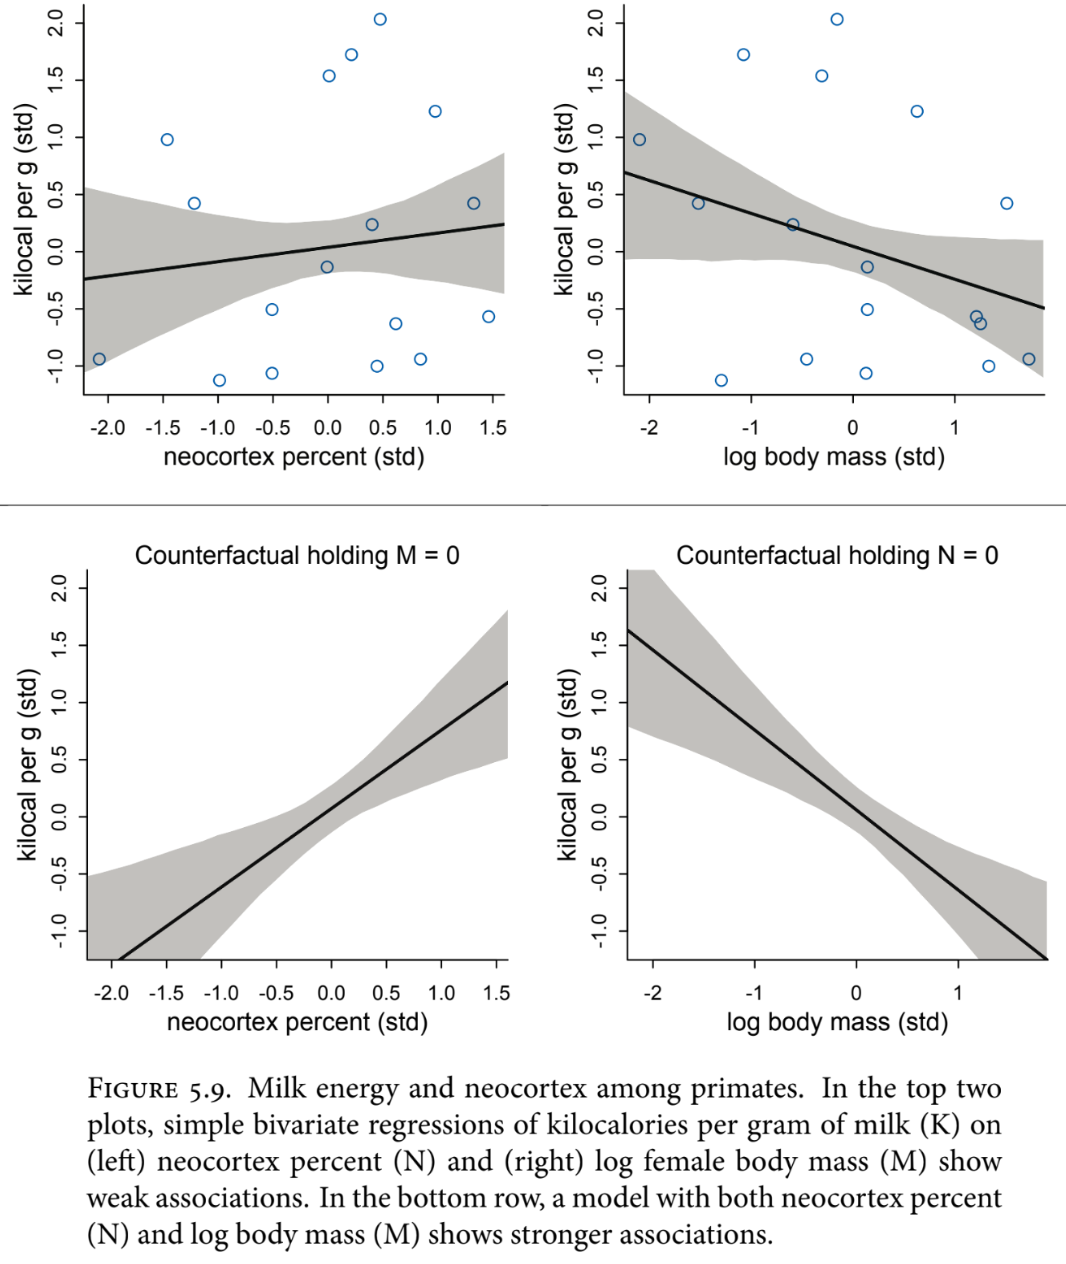

# Analysis

* We seem to see that the variables cancel each other, but if we fix one of them, the other is more strongly correlated (masking)
* The chapter analyses causual graphs consistent with the data:
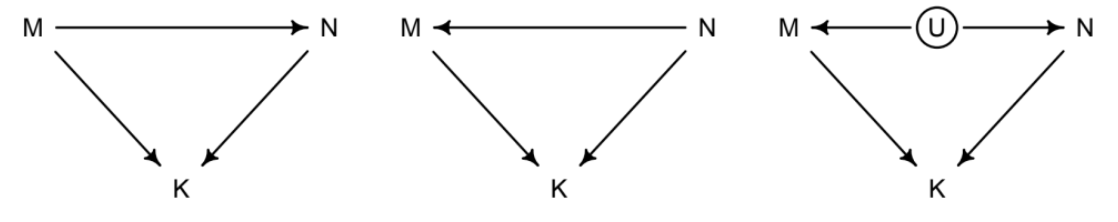
* Unfortunately we cannot decide which one is valid using correlations, as all generate the same conditional independencies.
* They are in the same __Markov Equivalence Set__
* In the end, it is not the data, but our background scientific knowledge (the big world) that stands for the correctness of these diagrams.
* Still multiple regression shown us that there are correlations from regressors to the target, even though we cannot see whether they are causal.

# Categorical Variables

* Not only continuous (numeric) variables can corelate, or influence regressions
* Examples: Sexmale/female, infant/juvenile/adult, Africa/Europe/Melanesia (and the states in the Waffle House example)
* Let us add a new variable `clade` (a group of organisms believed to comprise all the evolutionary descendants of a common ancestor.)

In [37]:
dcc.head()

<xarray.Dataset> Size: 480B
Dimensions:         (index: 5)
Coordinates:
  * index           (index) int64 40B 0 5 6 7 9
Data variables:
    clade           (index) object 40B 'Strepsirrhine' ... 'New World Monkey'
    species         (index) object 40B 'Eulemur fulvus' ... 'S sciureus'
    kcal.per.g      (index) float64 40B 0.49 0.47 0.56 0.89 0.92
    perc.fat        (index) float64 40B 16.6 21.22 29.66 53.41 50.58
    perc.protein    (index) float64 40B 15.42 23.58 23.46 15.8 22.33
    perc.lactose    (index) float64 40B 67.98 55.2 46.88 30.79 27.09
    mass            (index) float64 40B 1.95 5.25 5.37 2.51 0.68
    neocortex.perc  (index) float64 40B 55.16 64.54 64.54 67.64 68.85
    K               (index) float64 40B -0.9567 -1.083 -0.5153 1.565 1.755
    N               (index) float64 40B -2.144 -0.5243 -0.5243 0.01107 0.22
    M               (index) float64 40B -0.5249 -0.3894 -0.3844 -0.5019 -0.5771

In [38]:
np.unique(dcc.clade.values)

array(['Ape', 'New World Monkey', 'Old World Monkey', 'Strepsirrhine'],
      dtype=object)

* So we have 4 categories/levels for `clade`.
* Let's number them from 0 to 3 to be able to use them as indices
* We use pandas to convert the four categories to numbers. Pandas has a convenient API for this, and xarray has not ...

In [39]:
dcc["clade_id"] = ('index', pd.Categorical(dcc["clade"].values).codes)
dcc

<xarray.Dataset> Size: 2kB
Dimensions:         (index: 17)
Coordinates:
  * index           (index) int64 136B 0 5 6 7 9 10 11 ... 19 21 23 24 26 27 28
Data variables:
    clade           (index) object 136B 'Strepsirrhine' ... 'Ape'
    species         (index) object 136B 'Eulemur fulvus' ... 'Homo sapiens'
    kcal.per.g      (index) float64 136B 0.49 0.47 0.56 0.89 ... 0.48 0.55 0.71
    perc.fat        (index) float64 136B 16.6 21.22 29.66 ... 21.18 36.84 50.49
    perc.protein    (index) float64 136B 15.42 23.58 23.46 ... 11.68 9.54 9.84
    perc.lactose    (index) float64 136B 67.98 55.2 46.88 ... 67.14 53.62 39.67
    mass            (index) float64 136B 1.95 5.25 5.37 ... 40.74 33.11 54.95
    neocortex.perc  (index) float64 136B 55.16 64.54 64.54 ... 70.24 76.3 75.49
    K               (index) float64 136B -0.9567 -1.083 ... -0.5784 0.4305
    N               (index) float64 136B -2.144 -0.5243 -0.5243 ... 1.507 1.367
    M               (index) float64 136B -0.5249 -0.3894 ... 0.7553 1.653
    clade_id        (index) int8 17B 3 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0

$$K_i \sim \mathrm{Normal}(\mu_i, \sigma)$$
$$\mu_i = \alpha_{\mathrm{clade[i]}}$$
$$\alpha_j = \mathrm{Normal}(0, 0.5) \quad \text{ for j = 1..4 }$$
$$\sigma \sim \mathrm{Exponential}(1)$$

In [40]:
dcc.clade_id

<xarray.DataArray 'clade_id' (index: 17)> Size: 17B
array([3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0], dtype=int8)
Coordinates:
  * index    (index) int64 136B 0 5 6 7 9 10 11 12 15 17 19 21 23 24 26 27 28

In [41]:
with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    # shape defines a vector size (+1 because ids start from zero)
    # we will have four different mu's for K
    mu = pm.Normal("mu", 0, 0.5, shape=(dcc.clade_id.max() + 1,))
    # it is crazy implicit how pymc matches rows in d["clade_id"] and d["K"]
    K = pm.Normal("K", mu[dcc.clade_id.values], sigma, observed=dcc.K)

    m5_9_trace = pm.sample(random_seed = rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


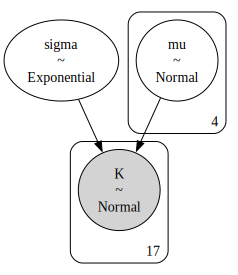

In [42]:
pm.model_graph.model_to_graphviz(m5_9)

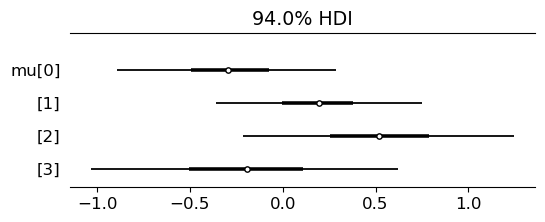

In [43]:
az.plot_forest(
    data = m5_9_trace, 
    colors = ["k"],
    kind = 'forestplot',
    # kind = 'ridgeplot',  # try ridgeplot instead for more information 
    var_names="mu", 
    hdi_prob=0.94, 
    combined = True, # plots the result for all four chains combined (try False)
    ridgeplot_alpha = .6,
    figsize = (6,2), 
    textsize = 12);

* This shows that the expected kcal in milk levels seem to be different for different clades.
* Importantly, the categorical terms are additive (we can more categorical variables, each with its own set of intercepts), so we can do mulitple regression with them as well.
* And we can also add them with continuous predictors (slopes) from numeric variables in multivariate analysis.